# **The Vehicle Type Classification Project**



# Summary


- **Use Case:** Vehicle Type
- **Algorithm:** MobileNetV2
- **Number of training images:** 603
- **Number of classes:** 7
- **Batch Size:** 64
- **Optimizer:** Adam 
- **Learning Rate:** 0.0001
- **Loss Type:**CategoricalCrossentropy
- **Transfer Learning:** Yes | Imagenet



 ## Labels
 
 0: 'car-bus-alltypes',

 1: 'car-sedan-alltypes',
 
 2: 'car-suv-alltypes',
 
 3: 'motocycle-bicycle-kids',
 
 4: 'motocycle-bicycle-racing',
 
 5: 'motocycle-motorbike-chopper',
 
 6: 'motocycle-motorbike-sport'

## Import Library

In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys

In [3]:
print(tf.__version__)

2.9.2


## 구글드라이브 마운트 하기

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 다음 데이터셋을 다운로드하여, 압축을 풀고, 구글 드라이브에 올려놓는다.

https://block-yh-test1.s3.amazonaws.com/38_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8%E1%84%91%E1%85%A1%E1%84%8B%E1%85%B5%E1%86%AF.zip


In [5]:
!wget --no-check-certificate https://block-yh-test1.s3.amazonaws.com/38_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8%E1%84%91%E1%85%A1%E1%84%8B%E1%85%B5%E1%86%AF.zip -O ./data.zip             

--2023-01-02 05:26:23--  https://block-yh-test1.s3.amazonaws.com/38_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8%E1%84%91%E1%85%A1%E1%84%8B%E1%85%B5%E1%86%AF.zip
Resolving block-yh-test1.s3.amazonaws.com (block-yh-test1.s3.amazonaws.com)... 52.217.137.1, 52.217.99.100, 52.217.109.124, ...
Connecting to block-yh-test1.s3.amazonaws.com (block-yh-test1.s3.amazonaws.com)|52.217.137.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 326052257 (311M) [application/zip]
Saving to: ‘./data.zip’

./data.zip          100%[===================>] 310.95M  12.8MB/s    in 27s     

2023-01-02 05:26:51 (11.7 MB/s) - ‘./data.zip’ saved [326052257/326052257]



In [6]:
! unzip data.zip

Archive:  data.zip
   creating: test-images/
  inflating: __MACOSX/._test-images  
  inflating: test-images/bicycle.png  
  inflating: __MACOSX/test-images/._bicycle.png  
  inflating: test-images/bus.jpg     
  inflating: __MACOSX/test-images/._bus.jpg  
   creating: trained-models/
  inflating: __MACOSX/._trained-models  
   creating: trained-models/mobilenetv2/
  inflating: __MACOSX/trained-models/._mobilenetv2  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-1.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classification-by-type-mobilenetv2-anis-1.h5  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-1-2.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classification-by-type-mobilenetv2-anis-1-2.h5  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-2.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classification-by-ty

## 경로 셋팅

In [7]:
TYPE='type'
model_type='mobilenetv2'
user='block'
iteration='1-2'

first_time_training=True

PROJECT_PATH= '/content/drive/MyDrive/Colab Notebooks/ml_plus'

HDF5_DATASET_PATH=PROJECT_PATH+'/vehicle_datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5'

TARGET_CLASSIFICATION_MODEL=PROJECT_PATH+'/trained-models/'+model_type+'/'+'vehicle-classification-by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'

CHECKPOINT_PATH = PROJECT_PATH+'/checkpoints/'+model_type+'/'+'by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'

LOGFILE_PATH=PROJECT_PATH+'/log/'+model_type+'/'+model_type+'-by-'+TYPE+'-training-log'+user+'-'+iteration+'.csv'


In [8]:
print('PROJECT_PATH: ',PROJECT_PATH)
print('HDF5_DATASET_PATH: ', HDF5_DATASET_PATH)
print('TARGET_CLASSIFICATION_MODEL: ',TARGET_CLASSIFICATION_MODEL)
print('CHECKPOINT_PATH: ',CHECKPOINT_PATH)
print('LOGFILE_PATH: ',LOGFILE_PATH)

PROJECT_PATH:  /content/drive/MyDrive/Colab Notebooks/ml_plus
HDF5_DATASET_PATH:  /content/drive/MyDrive/Colab Notebooks/ml_plus/vehicle_datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5
TARGET_CLASSIFICATION_MODEL:  /content/drive/MyDrive/Colab Notebooks/ml_plus/trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-block-1-2.h5
CHECKPOINT_PATH:  /content/drive/MyDrive/Colab Notebooks/ml_plus/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
LOGFILE_PATH:  /content/drive/MyDrive/Colab Notebooks/ml_plus/log/mobilenetv2/mobilenetv2-by-type-training-logblock-1-2.csv


In [9]:

sys.path.append(PROJECT_PATH)


In [10]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ml_plus')

# **Load the Dataset**

In [11]:
def load_dataset_from_hdf5_file(hdf_file_path):
  # 함수 만들기
  hf = h5py.File(hdf_file_path, 'r')

  X_train = np.array(hf['trainX'])
  y_train = np.array(hf['trainY'])
  train_label = np.array(hf['trainLabels'])

  X_test = np.array(hf['testX'])
  y_test = np.array(hf['testY'])
  test_label = np.array(hf['testLabels'])

  X_val = np.array(hf['devX'])
  y_val = np.array(hf['devY'])
  val_label = np.array(hf['devLabels'])

  return X_train, y_train, train_label, X_test, y_test, test_label, X_val, y_val, val_label
  

In [12]:
X_train, y_train, train_label, X_test, y_test, test_label, X_val, y_val, val_label=load_dataset_from_hdf5_file(HDF5_DATASET_PATH)

In [13]:
X_train.shape

(603, 224, 224, 3)

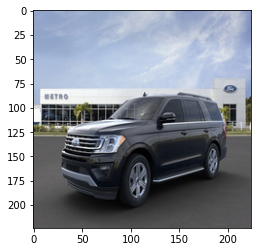

In [14]:
plt.imshow(X_train[3])
plt.show()

In [15]:
y_train[3]

array([0, 0, 1, 0, 0, 0, 0])

In [16]:
y_train[3].argmax()

2

In [17]:
train_label[3]

b'car-suv-alltypes'

In [18]:
X_train[0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [19]:
X_train[0].max()

1.0

In [20]:
X_train[0].min()

0.0

# 모델링하기 : 트랜스퍼 러닝 적용

# Data Augmentation

In [21]:
X_train.shape

(603, 224, 224, 3)

In [22]:
base_model = MobileNetV2(input_shape= (224,224,3) , include_top=False )

9406464/9406464 [==============================] - 0s 0us/step


In [23]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [24]:
base_model.trainable = False

In [25]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [26]:
head_model = base_model.output

In [27]:
head_model = Flatten()(head_model)

In [28]:
head_model = Dense(128, 'relu')(head_model)

In [29]:
head_model = Dropout(0.4)(head_model)

In [30]:
head_model = Dense(64, 'relu')(head_model)

In [31]:
head_model = Dense(7 , 'softmax')(head_model)

In [32]:
model = Model(inputs = base_model.input,  outputs = head_model )

###  콜백 만들기 : 가장 좋은 모델을 자동 저장하도록 함. 로그도 저장하도록 함.

In [33]:
# 파이썬 코드로, 디렉토리 만드는 방법

In [34]:
if not os.path.exists(PROJECT_PATH + '/checkpoints/' + model_type+'/') :
  os.makedirs(PROJECT_PATH + '/checkpoints/' + model_type+'/')

In [35]:
if not os.path.exists(PROJECT_PATH + '/log/' + model_type+'/') :
  os.makedirs(PROJECT_PATH + '/log/' + model_type+'/')

In [36]:
from keras.callbacks import ModelCheckpoint

In [38]:
mcp = ModelCheckpoint(CHECKPOINT_PATH, 
                      monitor='val_accuracy',
                      save_best_only=True,
                      verbose = 1)

In [39]:
# 에포크가 끝날때마다, 현재는 화면에 표시하는데, 
# 이 정보를, 파일로 저장해서, 화면 안보더라도, 나중에 
# 파일열어서 확인이 가능하도록, Log 를 남기는 방법

In [40]:
from keras.callbacks import CSVLogger

In [50]:
csv_logger = CSVLogger(LOGFILE_PATH, append= True)

## 컴파일과 학습 : 에포크는 50

In [43]:
y_train

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [44]:
model.compile(Adam(0.0001) , 'categorical_crossentropy', ['accuracy']  )

In [45]:
# 바로 학습하기 전에, 이미지 데이터 증강하고 학습한다.

In [47]:
#  X_train 을 확인해 보니, 이미 0~ 1사이의 값으로 피처 스케일링 되어있으므로
#  데이터증강만 한다.

In [48]:
train_datagen = ImageDataGenerator(rotation_range=10, horizontal_flip=True)

In [49]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)

In [51]:
epoch_history = model.fit(train_generator, epochs = 40, 
                          validation_data = (X_val, y_val) , 
                          batch_size = 64, 
                          callbacks = [mcp , csv_logger] )

Epoch 1/40
10/10 [==============================] - ETA: 0s - loss: 1.1835 - accuracy: 0.5672
Epoch 1: val_accuracy improved from -inf to 0.86667, saving model to /content/drive/MyDrive/Colab Notebooks/ml_plus/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
10/10 [==============================] - 18s 759ms/step - loss: 1.1835 - accuracy: 0.5672 - val_loss: 0.2619 - val_accuracy: 0.8667
Epoch 2/40
10/10 [==============================] - ETA: 0s - loss: 0.4282 - accuracy: 0.8458
Epoch 2: val_accuracy improved from 0.86667 to 0.93333, saving model to /content/drive/MyDrive/Colab Notebooks/ml_plus/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
10/10 [==============================] - 6s 639ms/step - loss: 0.4282 - accuracy: 0.8458 - val_loss: 0.2255 - val_accuracy: 0.9333
Epoch 3/40
10/10 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.9071
Epoch 3: val_accuracy did not improve from 0.93333
10/10 [==============================] - 7s 653ms/step 

# 트레이닝 및 밸리데이션의 정확도와 로스를 차트로 보기

In [53]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 160ms/step - loss: 0.2470 - accuracy: 0.9737


[0.24704787135124207, 0.9736841917037964]

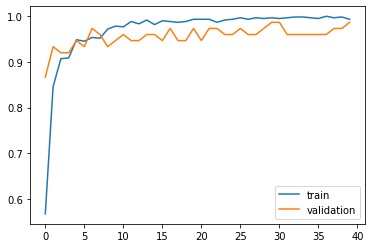

In [54]:
plt.plot( epoch_history.history['accuracy']  )
plt.plot( epoch_history.history['val_accuracy']  )
plt.legend( ['train', 'validation'] )
plt.show()

# 모델 평가

In [37]:
####  fine tuning 해본다. ######

In [55]:
# 1. base_model 을 먼저, 모두 학습 가능하도록 만들어 놓는다.

In [56]:
base_model.trainable = True

In [57]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [58]:
# 2. base_model의 레이어 수를 확인한다.

In [60]:
len( base_model.layers )

154

In [61]:
# 3. 몇번째 레이어까지 frozen 시킬지 결정한다.

In [63]:
end_layer = 130

In [64]:
# 4. base_model의 첫번째 레이어부터 end_layer 까지는 학습이 
#    되지 않도록 frozen 시킨다.

In [65]:
for layer in base_model.layers[0: end_layer+1 ] :
  layer.trainable = False

In [66]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [67]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [70]:
model.compile( Adam(0.0001) , 'categorical_crossentropy', ['accuracy'] )

In [71]:
epoch_history = model.fit(train_generator, 
                          epochs = 20, 
                          validation_data = (X_val, y_val) , 
                          callbacks = [mcp, csv_logger] ,
                          batch_size = 64)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9519
Epoch 1: val_accuracy did not improve from 0.98667
10/10 [==============================] - 10s 594ms/step - loss: 0.1542 - accuracy: 0.9519 - val_loss: 0.1351 - val_accuracy: 0.9200
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9701
Epoch 2: val_accuracy did not improve from 0.98667
10/10 [==============================] - 6s 603ms/step - loss: 0.0682 - accuracy: 0.9701 - val_loss: 0.0495 - val_accuracy: 0.9733
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9851
Epoch 3: val_accuracy did not improve from 0.98667
10/10 [==============================] - 7s 737ms/step - loss: 0.0487 - accuracy: 0.9851 - val_loss: 0.1023 - val_accuracy: 0.9467
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9900
Epoch 4: val_accuracy did not improve from 0.98667
10/10 [===================

In [72]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 44ms/step - loss: 0.2348 - accuracy: 0.9605


[0.23484225571155548, 0.9605262875556946]

In [ ]:
### 가장 좋은 모델은 어디에 저장??  여러분 구글드라이브에 있다.

In [73]:
### 구글드라이브에 저장된, 가장 좋은 모델을 불러와서 테스트 해본다.

In [74]:
CHECKPOINT_PATH

'/content/drive/MyDrive/Colab Notebooks/ml_plus/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5'

In [75]:
best_model = tf.keras.models.load_model(CHECKPOINT_PATH)

In [76]:
best_model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 43ms/step - loss: 0.2834 - accuracy: 0.9605


[0.2833544611930847, 0.9605262875556946]